# Setup
Start off by important dependencies and importing our dataset

In [ ]:
!unzip -q stanford_cars_data.zip

[stanford_cars_data.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of stanford_cars_data.zip or
        stanford_cars_data.zip.zip, and cannot find stanford_cars_data.zip.ZIP, period.


In [1]:
!pip install denoising_diffusion_pytorch > /dev/null 2>&1

In [2]:
import sys
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import transforms
import logging
from datetime import datetime
from PIL import Image

from denoising_diffusion_pytorch import Unet as GithubUnet
from denoising_diffusion_pytorch import GaussianDiffusion

Then we define the hyperparameters

In [3]:
IMG_SIZE=64
BATCH_SIZE=64
T=300
EPOCHS=100
LEARING_RATE=0.001

# Dataloader

In [4]:
class AnimeFaces(Dataset):
    def __init__(self, img_dir, preprocess):
        super().__init__()

        self.img_dir = img_dir
        self.preprocess = preprocess

    def __len__(self):
        png_files = [f for f in os.listdir(self.img_dir) if f.endswith('.png') and os.path.isfile(os.path.join(self.img_dir, f))]
        return len(png_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, str(index+1)+'.png')
        img_file = Image.open(img_path)

        if self.preprocess != None:
            img_file = self.preprocess(img_file)

        return img_file

Now let's import our data and transform it.

In [5]:
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# setup logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)


# Determine mean and variance of pixel values
transformations = [
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),                 # scale to [0, 1]
    transforms.Lambda(lambda t: (t*2) - 1) # scale to [-1, 1]
]
preprocess = transforms.Compose(transformations)

dataset = AnimeFaces(img_dir='data', preprocess=preprocess)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

RECOMPUTE_NORMS=False
# computed previously
norm_mean, norm_std = [25.66350674, 12.87127401, 11.44491336], [202.07254913, 101.43154071, 90.1956577]
if RECOMPUTE_NORMS:
    norm_mean, norm_std = normalize_dataset(dataloader, IMG_SIZE, IMG_SIZE)

print('norms computed', norm_mean, norm_std)

# Apply the normalization transformations
# transformations.append(transforms.Normalize(mean=norm_mean, std=norm_std))
preprocess = transforms.Compose(transformations)
dataset = AnimeFaces(img_dir='data', preprocess=preprocess)
scaled_len = len(dataset)//BATCH_SIZE * BATCH_SIZE
dataset = Subset(dataset, range(scaled_len)) # truncate to multiple of batch size
#dataset = Subset(dataset, range(BATCH_SIZE*4)) # truncate to multiple of batch size
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


cuda
norms computed [25.66350674, 12.87127401, 11.44491336] [202.07254913, 101.43154071, 90.1956577]


We also need a mechanic to convert back to a viewable image once we are ready to display it.

In [6]:
# converts from a tensor to viewable image
# removes the normalization that is done
reverse_transformations = transforms.Compose([
    transforms.Lambda(lambda t: (t+1)/2),
    transforms.Lambda(lambda t: t.permute(1, 2, 0)),
    transforms.Lambda(lambda t: t*255.),
    transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
    transforms.ToPILImage()
])

# Scheduler
Next we will need a noise scheduler

In [7]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

# TODO cosine schedule still doesn't look correct
def cosine_schedule(T, s=0.008):
    t = torch.linspace(0, T, T+1)
    alphas_overline = torch.cos((t/T + s)/(1+s) * torch.pi/2) ** 2
    alphas_overline = alphas_overline/alphas_overline[0]
    betas = 1 - (alphas_overline[1:] / alphas_overline[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

class Sampler:
    def __init__(self, schedule):
        self.betas = schedule
        self.alphas = 1. - self.betas
        self.alphas_overline = torch.cumprod(self.alphas, axis=0)
        self.A = torch.sqrt(self.alphas_overline)
        self.B = torch.sqrt(1.-self.alphas_overline)
        self.variance = self.betas

    def _extract(self, tensor, t, x_shape):
        batch_size = t.shape[0]
        sampled_tensor = tensor.gather(-1, t.cpu())
        sampled_tensor = torch.reshape(sampled_tensor, (batch_size,) + (1,) * (len(x_shape) - 1))
        return sampled_tensor.to(t.device)

    def forward_sample(self, x, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x).to(x.device)

        A_t = self._extract(self.A, t, x.shape)
        B_t = self._extract(self.B, t, x.shape)
        # TODO double check variance
        #print('sampling from device', A_t.device, x.device, B_t.device, noise.device)
        return A_t * x + B_t * noise, noise

    @torch.no_grad()
    def reverse_sample(self, predict, x, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x).to(x.device)

        betas_t = self._extract(self.betas, t, x.shape)
        alphas_t = self._extract(self.alphas, t, x.shape)
        B_t = self._extract(self.B, t, x.shape)
        variance_t = self._extract(self.variance, t, x.shape)

        variance = torch.sqrt(variance_t) * noise if t > 0 else 0
        sqrt_recip_alphas_t = torch.sqrt(1./alphas_t)
        C = betas_t/B_t
        mean = sqrt_recip_alphas_t * (x - C * predict)
        return mean + variance


# TODO the noise still gets destroyed very fast

linear_sampler = Sampler(linear_beta_schedule(T))
cosine_sampler = Sampler(cosine_schedule(T))

We can try loading our data and applying noise to it now

image shape torch.Size([1, 3, 64, 64])


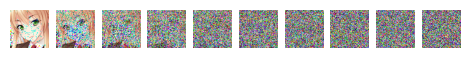

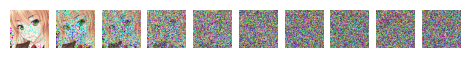

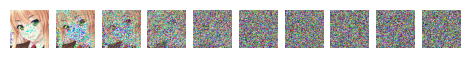

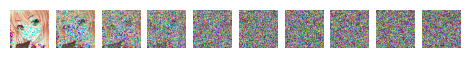

In [8]:

def visualize_sampler(original_image, sampler):
  '''
  visualize the effects of the noise schedule
  '''
  #print('original_image', original_image.shape)
  num_images = 10 # number of images to display in graph
  step_size = int(T/num_images)

  plt.figure()

  fig_index = 1
  for t in range(0, T, step_size):
      t = (torch.ones(1) * t).long().to(device)
      image, noise = sampler.forward_sample(original_image, t)
      plt.subplot(1, num_images+1, fig_index)
      plt.imshow(reverse_transformations(image[0].cpu()))
      plt.axis('off')
      fig_index += 1

  plt.show()

# grab an image from the dataloader
original_image = next(iter(dataloader))[0].unsqueeze(0).to(device) # grab some image
print('image shape', original_image.shape)

visualize_sampler(original_image, linear_sampler)
visualize_sampler(original_image, cosine_sampler)
visualize_sampler(original_image, Sampler(cosine_schedule(T, s=0.002)))
visualize_sampler(original_image, Sampler(cosine_schedule(T, s=0.1)))

# Neural network
For our backwards pass, we now need to train a Unet to predict the amount of noise to remove in each timestep. We begin by defining our position embedding.

In [ ]:
# inspired by https://towardsdatascience.com/diffusion-model-from-scratch-in-pytorch-ddpm-9d9760528946
class PositionEmbedding(nn.Module):
    def __init__(self, time_steps, dim):
        super().__init__()
        self.dim = dim
        self.time_steps = time_steps
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(-1 * math.log(10000) * torch.arange(0, self.dim, step=2).float()/(self.dim))
        self.embedding = torch.zeros(time_steps, self.dim, requires_grad=False)
        self.embedding[: , 0::2] = torch.sin(position * div)
        self.embedding[: , 1::2] = torch.cos(position * div)

    def forward(self, x, t):
        # print('dimensions', x.shape, t.shape)
        embeds = self.embedding.to(device)[t.squeeze(-1)].to(x.device)
        return embeds[:, :, None, None]



And then our unet implementation

In [ ]:
def crop(x, residual):
    _, _, H, W = x.shape
    return torchvision.transforms.CenterCrop([H, W])(residual)

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, up=True):
        super().__init__()

        self.time_dim = time_dim
        self.time_transform = nn.Linear(self.time_dim, in_channels)

        self.conv0 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.relu = nn.ReLU()

        if up:
            self.transform = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        else:
            self.transform = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x, t, residual=None):
        # TODO when should time embedding be applied?

        # transform time embedding
        t = self.time_transform(t)
        t = t[(...,) + (None,)*2] # add h and width dimentions
        logger.debug('time transform %s %s', t.shape, x.shape)

        x = x+t
        x = self.conv0(x)
        x = self.relu(x)
        logger.debug('block conv0+relu %s', x.shape)
        x = self.transform(x)
        saved_residual=x
        logger.debug('block transform %s', x.shape)

        if residual is not None:
            cropped = crop(x, residual)
            logger.debug('before crop %s', x.shape)
            x = torch.cat([x, cropped], dim=1)
            logger.debug('after crop %s', x.shape)

        x = self.conv1(x)
        x = self.relu(x)
        logger.debug('block conv1+relu %s', x.shape)
        return x, saved_residual


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2, time_dim=32):
        super().__init__()

        down_channels = [64, 128, 256, 512, 1024]
        up_channels = [1024, 512, 256, 128, 64]

        self.time_dim = time_dim

        # TODO move the max time steps to hyperparam
        self.time_embed = PositionEmbedding(1000, self.time_dim)
        self.time_embed_linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.time_dim, self.time_dim),
            nn.ReLU(),
        )

        self.conv0 = nn.Conv2d(in_channels, down_channels[0], 3, padding=1)
        self.down_blocks = nn.ModuleList([UNetBlock(down_channels[i], down_channels[i+1], self.time_dim, up=False) for i in range(len(down_channels)-1)])
        self.up_blocks = nn.ModuleList([UNetBlock(up_channels[i], up_channels[i+1], self.time_dim, up=True) for i in range(len(down_channels)-1)])
        self.conv1 = nn.Conv2d(up_channels[-1], up_channels[-1], 3, padding=1)
        self.output_conv = nn.Conv2d(up_channels[-1], out_channels, kernel_size=1)


    def forward(self, x, timestep):

        # time embedding
        t = self.time_embed(x, timestep)
        logger.debug('time embedding %s', t.shape)
        t = self.time_embed_linear(t)
        logger.debug('time embedding %s', t.shape)

        logger.debug('initial dimension %s', x.shape)
        x = self.conv0(x.float())
        logger.debug('after conv0 %s', x.shape)

        residuals = []
        for layer in self.down_blocks:
            (x, residual) = layer(x, t)
            residuals.append(residual)
            # logger.debug('appended', x.shape)

        # for r in residuals:
        #     logger.debug(r.shape)

        # we don't need the last residual connection
        logger.debug('residual len %s', len(residuals))

        logger.debug('after down blocks%s ', x.shape)

        for layer in self.up_blocks:
            residual = residuals.pop()
            # logger.debug('popped', residual.shape)
            x, _ = layer(x, t, residual=residual)

        logger.debug('shape after up_blocks %s', x.shape)
        x = self.conv1(x)
        logger.debug('shape after conv1 %s', x.shape)
        x = self.output_conv(x)
        logger.debug('shape after output conv %s', x.shape)
        return x



## Sampling

In [9]:
@torch.no_grad()
def evaluate_model(sampler, model):
    num_images = 10 # number of images to display in graph
    step_size = int(T/num_images)

    plt.figure()

    fig_index = 1
    image = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)
    #print('original image', image)
    for i in range(T-1, 0, -1):
        #print('image', image)
        t = (torch.ones(1) * i).long().to(device)
        #print('image before', image)
        predict = model(image, t)
        #print('predict', predict)
        image = sampler.reverse_sample(predict, image, t)
        image = torch.clamp(image, -1.0, 1.0)

        if i % step_size == 0:
            plt.subplot(1, num_images+1, fig_index)
            plt.imshow(reverse_transformations(image[0].cpu()))
            plt.axis('off')
            fig_index += 1

    plt.show()



# Training loop

Total parameters: 35711491
finished iteration 1/336, Loss: 0.4618088901042938


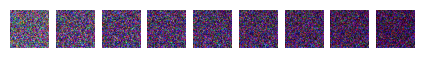

finished iteration 51/336, Loss: 0.11896145343780518


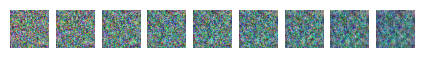

finished iteration 101/336, Loss: 0.09562258422374725


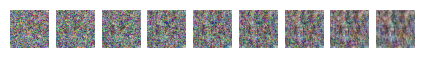

finished iteration 151/336, Loss: 0.06698797643184662


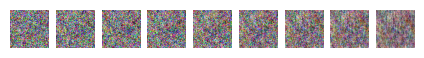

finished iteration 201/336, Loss: 0.05729367583990097


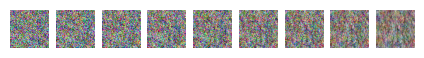

finished iteration 251/336, Loss: 0.05512349307537079


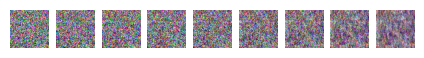

finished iteration 301/336, Loss: 0.05832443758845329


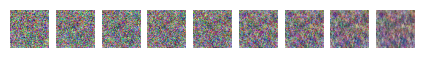

Completed Epoch 0, Loss: 0.10846120040375917
finished iteration 1/336, Loss: 0.05958900973200798


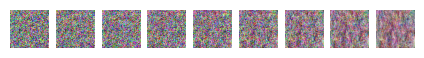

In [ ]:
# For use when saving model
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")

#model = UNet(in_channels=3, out_channels=3, time_dim=BATCH_SIZE)
model = GithubUnet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = False
)
sampler = linear_sampler

model.to(device)
# print(model)
total_params = sum(p.numel() for p in model.parameters())
print('Total parameters:', total_params)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARING_RATE)
criterion = nn.MSELoss()

# Training process
for epoch in range(EPOCHS):

    total_loss = 0
    for i, batch in enumerate(dataloader):
        model.train()

        optimizer.zero_grad()

        # sample random timestep
        t = torch.randint(0, T, (BATCH_SIZE, ), device=device)
        e, noise = sampler.forward_sample(batch.to(device), t)
        outputs = model(e, t)

        loss = F.smooth_l1_loss(outputs, noise)

        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f'finished iteration {i+1}/{len(dataloader)}, Loss: {loss}')
            # TODO visualize the current performance
            evaluate_model(sampler, model)


    print(f'Completed Epoch {epoch}, Loss: {total_loss/len(dataloader)}')


    # save model
    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'norm_mean': norm_mean,
        'norm_std': norm_std,
    }
    torch.save(checkpoint, f'checkpoints/model_{timestamp}.pth')

# Inference

In [ ]:
# load model of choice
checkpoint_path = '/content/checkpoints/stock.pth'
checkpoint = torch.load(checkpoint_path)

#model = UNet(in_channels=3, out_channels=3, time_dim=BATCH_SIZE)
model = GithubUnet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = False
)
model.load_state_dict(checkpoint['weights'])
model.to(device)

image_count = 10 # number of images to show in result
fig_index = 1
sample_indices = [int(T/image_count) * (i+1) - 1 for i in range(image_count)]

plt.figure()

with torch.no_grad():
    # generate an image
    x_t = torch.randn((1, 3, IMG_SIZE, IMG_SIZE))
    for t in range(T-1, 1, -1):
        z = 0
        if t > 1:
            z  = torch.randn((1, 3, IMG_SIZE, IMG_SIZE))

        t = torch.tensor([t])
        predict = model(x_t, t)
        # print('predict', predict.shape)
        sigma_t = torch.sqrt(cosine_sampler.betas[t].view(1,1,1,1)) # TODO get the variance
        # print('alphas', t.shape, alphas[t].view(1,1,1,1).shape)
        x_t = 1/torch.sqrt(cosine_sampler.alphas[t].view(1,1,1,1)) * (x_t - (1-cosine_sampler.alphas[t].view(1,1,1,1))/torch.sqrt(1-cosine_sampler.alphas_overline[t].view(1,1,1,1)) * predict + sigma_t * z)
        # print('x_t', x_t.shape)

        # TODO this is pretty stupid
        if t in sample_indices:
            print(t)
            plt.subplot(1, image_count+1, fig_index)
            # TODO make reverse_transformations work with batch
            plt.imshow(reverse_transformations(x_t.squeeze(0)))
            fig_index += 1

# show image
plt.show()

<ipython-input-13-4197214c699a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

<Figure size 640x480 with 0 Axes>